In [1]:
import pandas as pd
import numpy as np
import librosa
import glob
from natsort import natsorted
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
import seaborn as sns

/Users/kishi/Documents/ローカルコード/★データ分析/【練習問題】音楽ラベリング/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# メタデータの読み込み
train_master = pd.read_csv('train_master.csv', index_col=0) 
label_master = pd.read_csv('label_master.csv')
sample_submit = pd.read_csv('sample_submit.csv', header=None)

label_list = label_master.to_dict()['label_name']
print("ラベル:", label_list)
print("訓練データ数:", len(train_master))

ラベル: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
訓練データ数: 500


In [21]:
# 訓練データのMFCC特徴量を抽出
def extract_mfcc(file_path, n_mfcc=13, max_len=1225):
    """MFCCを抽出し、固定長にする"""
    try:
        y, sr = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # 固定長にパディング/トリミング
        if mfccs.shape[1] < max_len:
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant') 
        else:
            mfccs = mfccs[:, :max_len]

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 訓練データのMFCC特徴量を抽出
train_files = natsorted(glob.glob('train_sound*/train_*.au'))
print(f"訓練ファイル数: {len(train_files)}")

X_train = []
y_train = []

for i, file_path in enumerate(train_files):
    if i % 50 == 0:
        print(f"処理中: {i}/{len(train_files)}")

    mfccs = extract_mfcc(file_path)
    if mfccs is not None:
        X_train.append(mfccs)
        # ファイル名からインデックスを取得してラベルを設定
        file_index = int(file_path.split('_')[-1].split('.')[0])
        y_train.append(train_master.iloc[file_index]['label_id'])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"訓練データ形状: {X_train.shape}")
print(f"ラベル形状: {y_train.shape}")

訓練ファイル数: 500
処理中: 0/500
処理中: 50/500
処理中: 100/500
処理中: 150/500
処理中: 200/500
処理中: 250/500
処理中: 300/500
処理中: 350/500
処理中: 400/500
処理中: 450/500
訓練データ形状: (500, 13, 1225)
ラベル形状: (500,)


In [33]:
X_train[0]

array([[[-2.91544373e+02],
        [-3.26970276e+02],
        [-3.71576508e+02],
        ...,
        [-2.60999573e+02],
        [-1.66525177e+02],
        [-9.66781006e+01]],

       [[ 1.33274597e+02],
        [ 1.43878922e+02],
        [ 1.49978806e+02],
        ...,
        [ 7.11506500e+01],
        [ 1.93137684e+01],
        [ 4.49514008e+01]],

       [[ 1.29253311e+01],
        [ 1.34258518e+01],
        [ 5.06402111e+00],
        ...,
        [ 2.60522270e+01],
        [ 6.98082256e+00],
        [-5.39073277e+00]],

       ...,

       [[-3.47505927e+00],
        [-3.19937468e-01],
        [-3.37925494e-01],
        ...,
        [-1.79991913e+01],
        [-3.08286018e+01],
        [-3.73384018e+01]],

       [[ 1.76321137e+00],
        [-1.20951080e+00],
        [ 1.04653919e+00],
        ...,
        [ 1.44366045e+01],
        [ 8.17303467e+00],
        [ 4.20981550e+00]],

       [[-5.62284184e+00],
        [-7.71315861e+00],
        [-9.62504625e-01],
        ...,
        

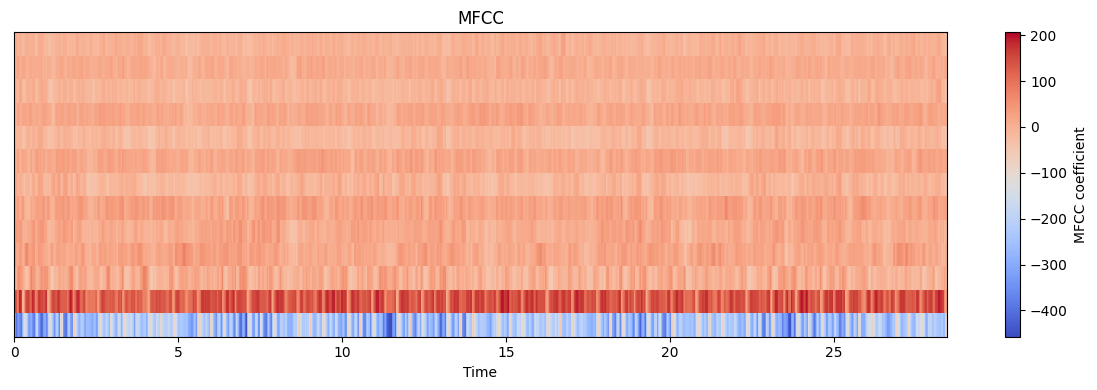

最大フレーム数: 1225, 特徴量次元数: 13
27011250


In [22]:
train_files = natsorted(glob.glob('train_sound*/train_*.au'))
sample_file = train_files[0]
y, sr = librosa.load(sample_file)

plt.figure(figsize=(12, 4))
librosa.display.specshow(X_train[0], x_axis='time', sr=sr)
plt.colorbar(label='MFCC coefficient')
plt.title('MFCC')
plt.tight_layout()
plt.show()

max_len = 1225
str_ = f"最大フレーム数: {max_len}, 特徴量次元数: {X_train.shape[1]}"
print(str_)
print(sr * max_len)

In [23]:
# テストデータのMFCC特徴量を抽出
test_files = natsorted(glob.glob('test_sound*/test_*.au'))
print(f"テストファイル数: {len(test_files)}")

X_test = []

for i, file_path in enumerate(test_files):
    if i % 50 == 0:
        print(f"処理中: {i}/{len(test_files)}")

    mfccs = extract_mfcc(file_path)
    if mfccs is not None:
        X_test.append(mfccs)

X_test = np.array(X_test)
print(f"テストデータ形状: {X_test.shape}")

テストファイル数: 500
処理中: 0/500
処理中: 50/500
処理中: 100/500
処理中: 150/500
処理中: 200/500
処理中: 250/500
処理中: 300/500
処理中: 350/500
処理中: 400/500
処理中: 450/500
テストデータ形状: (500, 13, 1225)


In [24]:
# データの前処理
# CNNのために次元を追加（チャンネル次元）
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],
X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],
X_test.shape[2], 1)

# ラベルをone-hot encodingに変換
y_train_categorical = to_categorical(y_train, num_classes=10)

# 訓練データを訓練用と検証用に分割
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_categorical, test_size=0.2, random_state=42,stratify=y_train)

print(f"訓練データ形状: {X_train_split.shape}")
print(f"検証データ形状: {X_val_split.shape}")
print(f"テストデータ形状: {X_test.shape}")

訓練データ形状: (400, 13, 1225, 1)
検証データ形状: (100, 13, 1225, 1)
テストデータ形状: (500, 13, 1225, 1)


In [27]:
# CNNモデルの構築（修正版）
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(13, 1225, 1), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# モデルのコンパイル
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# モデルの構造を表示
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 13, 1225, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 1225, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 612, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 612, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,090 (461.29 KB)

 Trainable params: 118,090 (461.29 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# モデルの訓練
history = model.fit(
    X_train_split, y_train_split,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_split, y_val_split),
    verbose=1
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - accuracy: 0.1551 - loss: 4.1465 - val_accuracy: 0.1400 - val_loss: 2.2400
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.1389 - loss: 2.2840 - val_accuracy: 0.2000 - val_loss: 2.1979
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - accuracy: 0.1997 - loss: 2.2428 - val_accuracy: 0.2000 - val_loss: 2.1805
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - accuracy: 0.1875 - loss: 2.2060 - val_accuracy: 0.2300 - val_loss: 2.1524
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - accuracy: 0.2305 - loss: 2.1503 - val_accuracy: 0.2500 - val_loss: 2.0710
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - accuracy: 0.2153 - loss: 2.1161 - val_accuracy: 0.2800 - val_loss: 2.0644
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - accuracy: 0.2359 - loss: 2.0985 - val_accuracy: 0.2800 - val_loss: 1.9808
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 346ms/step - accuracy: 0.2532 - loss: 2.0743 - val_accuracy: 0.

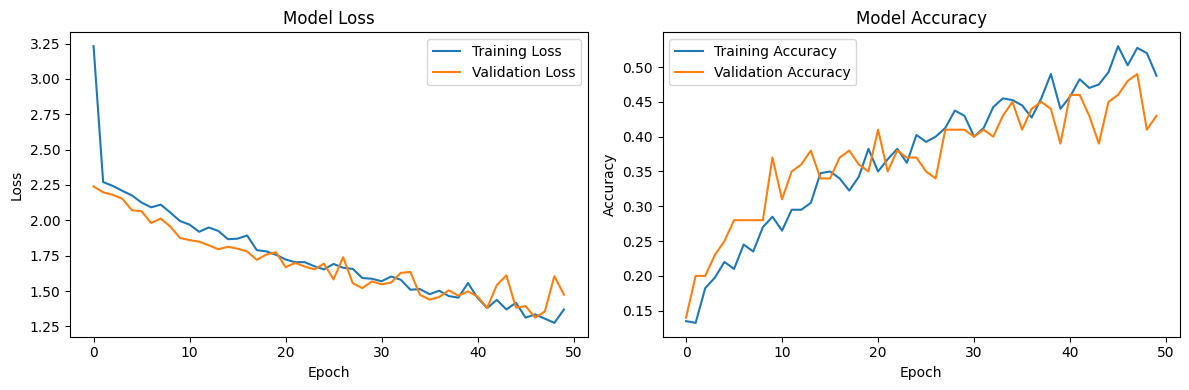

検証精度: 0.4300


In [29]:
# 訓練履歴の可視化
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 最終的な検証精度
val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split,
verbose=0)
print(f"検証精度: {val_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
分類レポート:
              precision    recall  f1-score   support

       blues       0.25      0.10      0.14        10
   classical       0.77      1.00      0.87        10
     country       0.09      0.10      0.10        10
       disco       0.60      0.30      0.40        10
      hiphop       1.00      0.20      0.33        10
        jazz       0.50      0.50      0.50        10
       metal       0.53      1.00      0.69        10
         pop       0.36      0.90      0.51        10
      reggae       0.25      0.10      0.14        10
        rock       0.14      0.10      0.12        10

    accuracy                           0.43       100
   macro avg       0.45      0.43      0.38       100
weighted avg       0.45      0.43      0.38       100



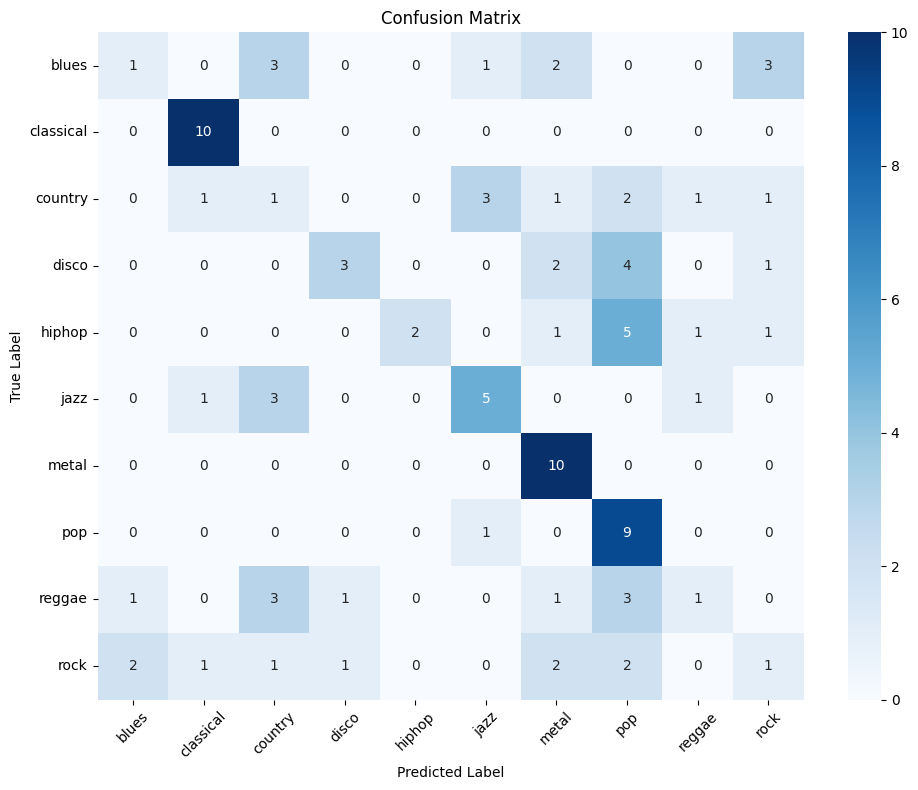

In [30]:
# 詳細な評価
y_pred = model.predict(X_val_split)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_split, axis=1)

# 分類レポート
print("分類レポート:")
print(classification_report(y_true_classes, y_pred_classes,
                            target_names=[label_list[i] for i in
range(10)]))

# 混同行列
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_list[i] for i in range(10)],
            yticklabels=[label_list[i] for i in range(10)])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


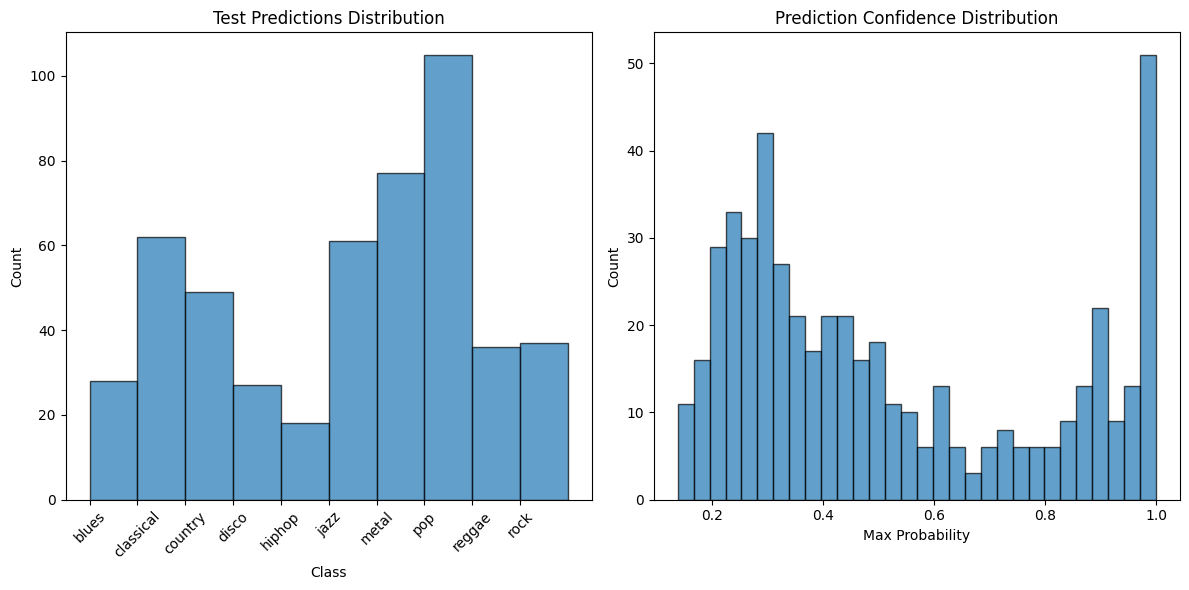

テストデータの予測完了: 500件
平均予測信頼度: 0.5172


In [31]:
# テストデータの予測
test_predictions = model.predict(X_test)
test_pred_classes = np.argmax(test_predictions, axis=1)

# 予測結果の確率分布を表示
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(test_pred_classes, bins=range(11), alpha=0.7,
edgecolor='black')
plt.title('Test Predictions Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(10), [label_list[i] for i in range(10)],
rotation=45)

# 予測の信頼度分布
plt.subplot(1, 2, 2)
max_probs = np.max(test_predictions, axis=1)
plt.hist(max_probs, bins=30, alpha=0.7, edgecolor='black')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Max Probability')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print(f"テストデータの予測完了: {len(test_pred_classes)}件")
print(f"平均予測信頼度: {np.mean(max_probs):.4f}")

In [32]:
# 結果をCSVファイルに保存
submission = pd.DataFrame({
    'id': sample_submit[0],
    'label_id': test_pred_classes
})

submission.to_csv('submission_cnn_mfcc.csv', index=False,
header=False)
print("予測結果をsubmission_cnn_mfcc.csvに保存しました")

# サンプル結果表示
print("\n予測結果の最初の10件:")
for i in range(10):
    print(f"Test {i}: {label_list[test_pred_classes[i]]} (信頼度: {max_probs[i]:.3f})")

予測結果をsubmission_cnn_mfcc.csvに保存しました

予測結果の最初の10件:
Test 0: pop (信頼度: 0.889)
Test 1: reggae (信頼度: 0.361)
Test 2: reggae (信頼度: 0.423)
Test 3: metal (信頼度: 0.996)
Test 4: classical (信頼度: 1.000)
Test 5: reggae (信頼度: 0.383)
Test 6: blues (信頼度: 0.427)
Test 7: blues (信頼度: 0.147)
Test 8: jazz (信頼度: 0.458)
Test 9: jazz (信頼度: 0.336)
